In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import CubicSpline
import math
tf.set_random_seed(12345)

In [2]:
tf.__version__

'1.15.0'

# Load data from Koh et al.

In [5]:
from scipy import interpolate
def load_exp_data(fileName):
    
    folderName = '../../data/koh/'
    phi_file = folderName  + fileName + "_phi_exp.csv"
    u_file = folderName  + fileName + "_u_exp.csv"
    df_phi = pd.read_csv(phi_file, header = None, names= ['y', 'phi'])
    df_phi = df_phi.sort_values(by=['y'])
    df_u = pd.read_csv(u_file, header = None, names= ['y', 'u'])
    df_u = df_u.sort_values(by=['y'])
    df_u = df_u.drop([17])

    L  = 1000
    y_coord = np.linspace(-1,1, L)
    
    # fit phi values
    fit_phi = interpolate.interp1d(df_phi['y'], df_phi['phi'], fill_value= 'extrapolate' )
    phi_fitted = fit_phi(y_coord)

    # fit u
    f = interpolate.interp1d(df_u['y'], df_u['u'], fill_value= 'extrapolate' )
    u_fitted = f(y_coord)

    u0 = u_fitted[L//2]
    u1 = u_fitted[-1]
    phim = 0.68

    eta = (1- df_phi['phi']/phim)**(-1.82)
    f = interpolate.interp1d(df_phi['y'], eta, fill_value= 'extrapolate' )
    eta_fitted = 0.5*(f(y_coord)+ f(-y_coord))

    G = (u1 - u0)/np.trapz(y_coord[L//2:]/eta_fitted[L//2:], y_coord[L//2:])
    print("G is: ", G)
    
    # create a data frame
    d = {'y': y_coord, 'phi': phi_fitted, 'u': u_fitted}
    df = pd.DataFrame(data=d)
    
    return df, df_u, df_phi, G

In [8]:
figures = ["koh_fig11", "koh_fig15", "koh_fig19"]
df, df_u_orig, df_phi,g = load_exp_data("koh_fig19")

G is:  -1.0472881733158999


In [9]:
df, df_u_orig, df_phi,g = load_exp_data("koh_fig15")

G is:  -1.2196653152147239


In [10]:
df, df_u_orig, df_phi,g = load_exp_data("koh_fig11")

G is:  -1.5063024209117382


# Theory

In [11]:
import math
from scipy.optimize import root_scalar as nsolve
from scipy.integrate import *

class solve_ode:
    def __init__(self, phi_b):
        self.y_final = []
        self.phi_final = []  
        self.phi_b = phi_b

    def solve_left(self):
        mytol = 1e-6
        sol0 = nsolve(self.func_left, bracket=[0, 1], method='brentq', xtol=mytol, rtol=mytol) 
        phi_0 = sol0.root
        return self.y_final, self.phi_final


    def ode_fun(self, y, phi):
        
        numerator = phi
        denom = (-1.38*phi/(1 - phi/0.68) - 1)*y

        return numerator/denom

    # define a function that returns "phi_solve - phi_b" given m  
    def func_left(self, phi0):
        y_dist = np.linspace(1, 0, 500)
        sol = solve_ivp(self.ode_fun, [1,0], [phi0], t_eval = y_dist) 
        
        self.y_final = sol.t
        self.phi_final = sol.y[0]
        I = simps(sol.y, sol.t)
        self.I = I 
        return I + self.phi_b

# PINN

In [12]:
class PINN_twoNNs:
    # Initialize the class
    def __init__(self, r, u, phi, layersU, layersPhi, l1, phi_b, G):
        
        self.l1 = l1
        self.r = r
        self.u = u
        self.umax = max(u)
        self.phi = phi
        self.phi_b = phi_b
        self.G = G
     
        self.layersU = layersU
        self.layersPhi = layersPhi
        # Initialize NN
        self.weightsU, self.biasesU = self.initialize_NN_u(self.layersU) 
        self.weightsPhi, self.biasesPhi = self.initialize_NN_phi(self.layersPhi)        
       
        # Initialize parameters
        self.lambda_1 = tf.Variable([self.l1], dtype=tf.float32)
         
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.r_tf = tf.placeholder(tf.float32, shape=[None, self.r.shape[1]])

        self.phi_tf = tf.placeholder(tf.float32, shape=[None,  self.phi.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])

        self.u_pred, self.ur_pred, self.urr_pred = self.net_NS_u(self.r_tf)

        self.phi_pred = self.net_NS_phi(self.r_tf)
        self.phir_pred = tf.gradients(self.phi_pred, self.r_tf)[0]
        
        self.eta = (1- self.phi_pred/0.68)**(-1.82)
        self.eta_r = 1.82/0.68*(1-self.phi_pred/0.68)**(-2.82)*self.phir_pred

        self.g_pred =  self.eta*self.ur_pred - self.G*self.r_tf

        self.Nc = self.lambda_1**2*self.phi_pred*(self.phi_pred*self.urr_pred + self.ur_pred*self.phir_pred)*self.eta
        self.Neta = self.phi_pred**2*self.ur_pred*self.eta_r
        self.f_pred = self.Nc + self.Neta 

        self.Nc_ = self.phi_pred*(self.phi_pred*self.urr_pred + self.ur_pred*self.phir_pred)
        self.Neta_ = self.phi_pred**2*self.ur_pred*self.eta_r/self.eta

        # loss function
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + tf.reduce_mean(tf.square(self.phi_tf - self.phi_pred)) + \
                    tf.reduce_mean(tf.square(self.g_pred)) + tf.reduce_mean(tf.square(self.f_pred)) +\
                    tf.square(tf.reduce_mean(self.phi_pred) - self.phi_b) 
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN_u(self, layersU):        
        weights = []
        biases = []
     
        num_layers = len(layersU) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layersU[l], layersU[l+1]])
            b = tf.Variable(tf.zeros([1,layersU[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)   

        return weights, biases

    def initialize_NN_phi(self, layersPhi):        
        weights = []
        biases = []
     
        num_layers = len(layersPhi) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layersPhi[l], layersPhi[l+1]])
            b = tf.Variable(tf.zeros([1,layersPhi[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)   

        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net_u(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_phi(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_NS_u(self,r):
     
        u = self.neural_net_u(r, self.weightsU, self.biasesU) # 

        u = u[:,0:1]
        # ub = u_ub[:, 1:2]
        u_r = tf.gradients(u, r)[0]
        u_rr = tf.gradients(u_r, r)[0]

        return u,u_r,u_rr 

    def net_NS_phi(self,r):
     
        phi = self.neural_net_phi(r, self.weightsPhi, self.biasesPhi) # 

        phi = phi[:,0:1]

  
        return phi

      
    def train(self, nIter): 

        tf_dict = {self.r_tf: self.r, self.u_tf: self.u, self.phi_tf: self.phi}
        
        start_time = time.time()
        Iteration, Loss, L1 = [0,], [float('inf')], [self.l1,]
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict) # minimize loss

            if it % 100 == 0:

                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
   
                Iteration.append(it)
                Loss.append(np.log(loss_value))
                L1.append((lambda_1_value[0]))
                
        print("Iterations done." )
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1])
        nc = self.sess.run(self.Nc, feed_dict=tf_dict)
        neta = self.sess.run(self.Neta, feed_dict=tf_dict)
        
        nc_ = self.sess.run(self.Nc_, feed_dict=tf_dict)
        neta_ = self.sess.run(self.Neta_, feed_dict=tf_dict)

        return Iteration, Loss, L1, nc, neta,  nc_, neta_
  
    def predict(self, r_star):
        
        tf_dict = {self.r_tf: r_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        phi_star = self.sess.run(self.phi_pred, tf_dict)

        return u_star, phi_star



In [9]:
def calcPINN(fileName, phib):
    # load data
    df, df_u_orig, df_phi, G = load_exp_data(fileName)
    
    # calc PINN
    N_train = int(0.7*len(df)) 
    layersU =  [1, 60, 60, 60, 60,60,  1]
    layersPhi =  [1, 60, 60, 60, 60,60, 1]
    
    ## Load Data
    N = len(df)
    U_star = df['u'].values  
    U_star = U_star.reshape(N,1)
    Phi_star = df['phi'].values 
    Phi_star = Phi_star.reshape(N,1)

    y = df['y'].values 
    R_star = y.reshape(N,1)

    ## Training Data    
    idx = np.random.choice(N, N_train, replace=False)
    r_train = R_star[idx]
    u_train = U_star[idx]
    phi_train = Phi_star[idx]

    ## Training: r, u, phi, Pe, layers
    l1 = 0.4
    model = PINN_twoNNs(r_train, u_train, phi_train, layersU, layersPhi, l1, phib, G)    
    Iteration, Loss, L1, Nc, Neta,  Nc_, Neta_ = model.train(10000)
    print(Loss[-1])
    r_star = R_star 
    u_star = U_star
    phi_star = Phi_star

    ## Prediction
    u_pred, phi_pred= model.predict(r_star)
    lambda_1_value = model.sess.run(model.lambda_1)

    print("kc/keta = ", lambda_1_value[0]**2)
    model.sess.close()
    

# Plot results: PINN + theory

In [13]:
def plot_result(fileName, r_star, u_pred, phi_pred, y_left, phi_left):
    
    df, df_u_orig, df_phi, G = load_exp_data(fileName)    
    
    figwidth = 9
    figheight = 4
    labelsize = 20
    ticksize = 15
    legendsize = 12

    fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
    widths = [figwidth/2, figwidth/2]
    heights = [figheight]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    axes = []
    for col in range(2):
        axes.append(fig.add_subplot(spec[0, col]))

    # exp data
    axes[0].plot(df_u_orig['y'], df_u_orig['u'], 'o', label = "Koh et al.")
    axes[1].plot(df_phi['y'][::2], df_phi['phi'][::2], 'o',label = "Koh et al.")

    # PINN result
    axes[0].plot(r_star, u_pred, '-',color ='r', label = "PINN")
    axes[1].plot(r_star, phi_pred, '-', color ='r',label = "PINN")

    # theory
    axes[1].plot(y_left, phi_left, '--', color = 'k', label = "Theory")
    axes[1].plot(-y_left, phi_left, '--', color = 'k')

    axes[0].set_xlabel(r"$y^*$",fontsize = labelsize)
    axes[0].set_ylabel(r"$u^*$",fontsize = labelsize)

    axes[1].set_xlabel(r"$y^*$",fontsize = labelsize)
    axes[1].set_ylabel(r"$\phi$",fontsize = labelsize)

    axes[0].set_ylim([0,1])

    axes[1].set_ylim([0,1])

    axes[0].legend(loc = 0,fontsize = legendsize)
    axes[1].legend(loc = 0,fontsize = legendsize)
    
    axes[0].tick_params(axis='both', labelsize=ticksize )      
    axes[1].tick_params(axis='both', labelsize=ticksize )      


In [14]:
figures = ["koh_fig11", "koh_fig15", "koh_fig19"]
phibs = [0.1, 0.2, 0.3]
def saveFig(i):
    phib = phibs[i]
    y_left, phi_left = solve_ode(phib).solve_left()
    folderName = '../../data/koh/'
    fileName = folderName + "pinn_res_" + figures[i] + ".csv"
    res_df = pd.read_csv(fileName )
    r_star, u_pred, phi_pred = res_df['r'], res_df['u'], res_df['phi']
    plot_result(figures[i], r_star, u_pred, phi_pred, y_left, phi_left)

In [16]:
from matplotlib import rc

font = {'family' : 'sans-serif',
        'sans-serif': ['Helvetica'],#['Helvetica'],
        'weight' : 'normal',
        'size': 8}

rc('font', **font) 
rc('text', usetex=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


G is:  -1.5063024209117382


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


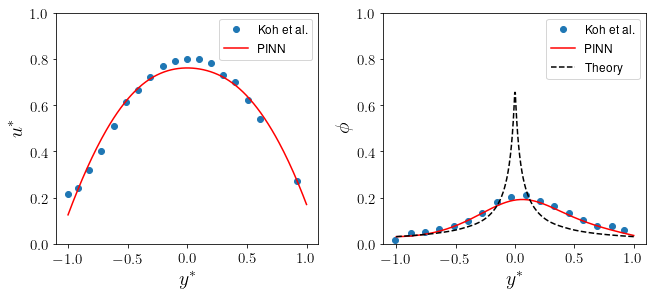

In [17]:
saveFig(0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


G is:  -1.2196653152147239


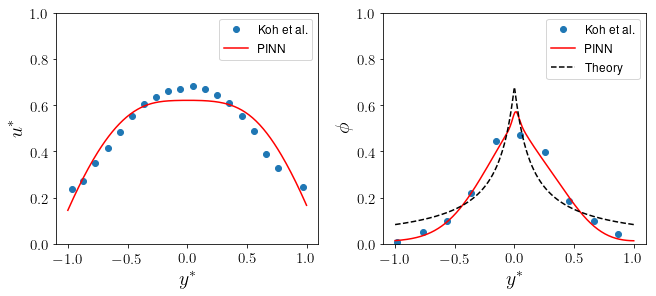

In [18]:
saveFig(1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


G is:  -1.0472881733158999


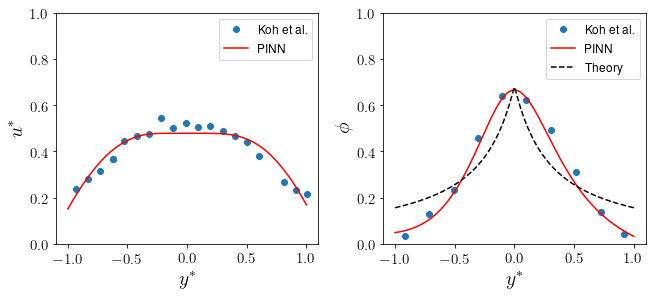

In [19]:
saveFig(2)